# LSTM을 이용한 주가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, Lambda

- Apple 주식 가격 예측

In [2]:
df = yf.download('AAPL', start='2010-01-01', end='2021-12-31', 
                 progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.425998,352410800
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.526021,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.537303,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.433319,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.421425,477131200


<AxesSubplot:xlabel='Date'>

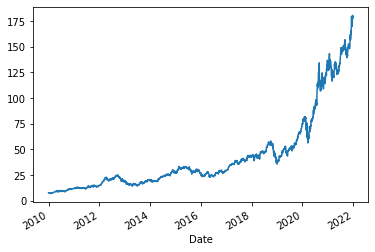

In [3]:
df.Close.plot()

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.

`len(df) - 100`일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.
### train/test split

In [4]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

data_training.shape, data_testing.shape

((2114, 1), (907, 1))

In [5]:
# scaler = MinMaxScaler()
# x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)
# x_scaled = scaler.fit_transform(x)
# print(x_scaled)
# print(scaler.scale_, scaler.min_, scaler.data_min_, scaler.data_max_)
# x_scaled / scaler.scale_ + scaler.data_min_

In [6]:
scaler = MinMaxScaler()
data_training_array = scaler.fit_transform(data_training)
data_training_array.shape

(2114, 1)

In [7]:
X_train = []
y_train = []
window = 100

for i in range(window, data_training.shape[0]):
    X_train.append(data_training_array[i-window: i])
    y_train.append(data_training_array[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2014, 100, 1), (2014,))

In [8]:
#data_training_array[:5]

In [9]:
#X_train[:5]

In [10]:
#y_train[:5]

** train data가 잘 만들어 졌는지 확인하는 Tip** 

- hist의 각 element는 window개 timestep의 list입니다. 1씩 증가하기 때문에 X_train의 **두 번째 element의 마지막 항목**은 target의 **첫 번째 element**와 같아야 합니다. 또한 **마지막 element의 마지막 항목**은 target의 마지막 2번째 element와 같아야 합니다.

In [11]:
X_train[1][-1][-1] == y_train[0]

True

In [12]:
X_train[-1][-1][-1] == y_train[-2]

True

- model 생성 및 fitting

In [13]:
model = tf.keras.Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=120))
model.add(Dropout(0.2))

model.add(Dense(60))
model.add(Dropout(0.2))
               
model.add(Dense(units=1))

model.summary()

2022-08-11 09:25:29.844077: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 30)           3840      
                                                                 
 dropout (Dropout)           (None, 100, 30)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           21840     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 120)               86880     
                                                                 
 dropout_2 (Dropout)         (None, 120)               0         
                                                                 
 dense (Dense)               (None, 60)                7

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
63/63 [==============================] - 8s 74ms/step - loss: 0.0165
Epoch 2/20
63/63 [==============================] - 5s 72ms/step - loss: 0.0035
Epoch 3/20
63/63 [==============================] - 5s 72ms/step - loss: 0.0033
Epoch 4/20
63/63 [==============================] - 5s 76ms/step - loss: 0.0026
Epoch 5/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0027
Epoch 6/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0024
Epoch 7/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0024
Epoch 8/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0024
Epoch 9/20
63/63 [==============================] - 5s 74ms/step - loss: 0.0020
Epoch 10/20
63/63 [==============================] - 5s 75ms/step - loss: 0.0021
Epoch 11/20
63/63 [==============================] - 5s 79ms/step - loss: 0.0025
Epoch 12/20
63/63 [==============================] - 5s 78ms/step - loss: 0.0020
Epoch 13/20
63/63 [==================

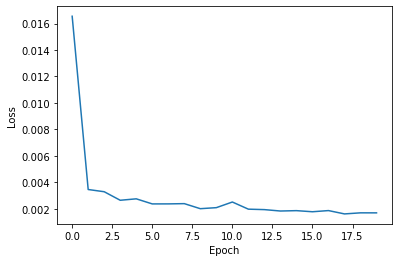

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오. 첫번째 예측을 위해 과거 window 일 수 만큼의 data 가 필요하므로 training data의 마지막 window 갯수 만큼을 concatenate 합니다.

In [16]:
past_window_days = data_training.tail(window)
final_df = pd.concat([past_window_days, data_testing])
final_df.shape

(1007, 1)

In [17]:
input_data = scaler.fit_transform(final_df)
input_data.shape

(1007, 1)

In [18]:
X_test = []
y_test = []
for i in range(window, input_data.shape[0]):
    X_test.append(input_data[i-window:i])
    y_test.append(input_data[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((907, 100, 1), (907,))

In [19]:
X_test[1][-1][-1] == y_test[0]

True

In [20]:
X_test[-1][-1][-1] == y_test[-2]

True

In [21]:
y_predicted = model.predict(X_test)
y_predicted.shape

(907, 1)

In [22]:
scaler.scale_, scaler.data_min_

(array([0.00690691]), array([35.54750061]))

In [26]:
y_predicted = y_predicted / scaler.scale_ + scaler.data_min_
y_test = y_test / scaler.scale_ + scaler.data_min_

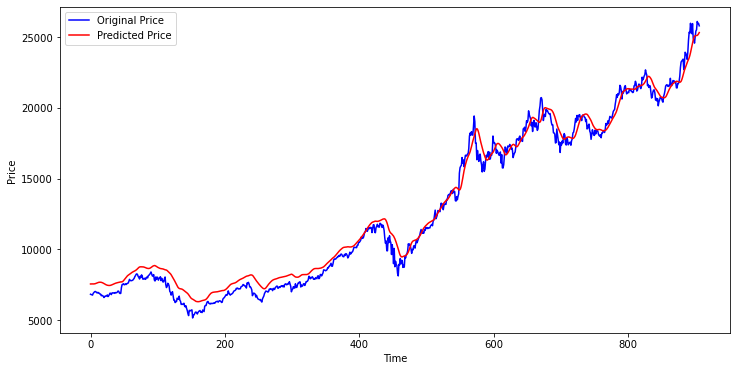

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

최근 일자 부분만 확대하여 시각화

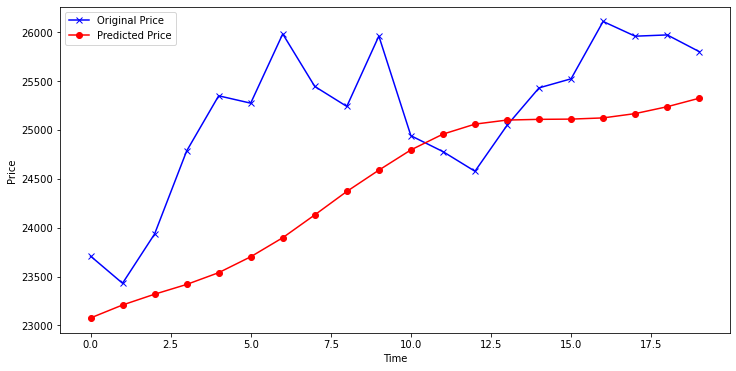

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(y_test[-20:], 'bx-', label='Original Price')
plt.plot(y_predicted[-20:], 'ro-', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 다양한 window_size tuning 을 하여 보다 정확한 예측 시도